In [1]:
# %% [markdown]
# # Trading Risk Model Analysis
# This notebook trains regression models to predict next day's total_delta (P&L) and compares them with ARIMA baseline

# %% Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Import our modules
from src.data_loader import DataLoader
from src.feature_engineering import FeatureEngineer
from src.model_trainer import ModelTrainer
from src.predictor import RiskPredictor

# Set up plotting
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# %% [markdown]
# ## 1. Load and Prepare Data

# %% Load data
print("Loading data...")
data_loader = DataLoader()
all_data = data_loader.load_all_traders_data()

# Create master dataset
master_totals, master_fills = data_loader.create_master_dataset(all_data)

print(f"Loaded data for {len(all_data)} traders")
print(f"Total records: {len(master_totals)}")
print(f"Date range: {master_totals['date'].min()} to {master_totals['date'].max()}")

2025-05-26 11:14:01,247 - INFO - Loaded 5 trader accounts from config


Loading data...


2025-05-26 11:14:02,365 - INFO - Loaded data for 3957: 654 trading days
2025-05-26 11:14:02,756 - INFO - Loaded data for 3950: 471 trading days
2025-05-26 11:14:02,869 - INFO - Loaded data for 3946: 532 trading days
2025-05-26 11:14:03,203 - INFO - Loaded data for 4004: 493 trading days
2025-05-26 11:14:03,299 - INFO - Loaded data for 3951: 338 trading days
2025-05-26 11:14:03,300 - INFO - Successfully loaded data for 5 traders
2025-05-26 11:14:06,026 - INFO - Created master dataset with 1377246 fill records and 14642 total records


Loaded data for 5 traders
Total records: 14642
Date range: 2023-04-03 00:00:00 to 2025-04-30 00:00:00


2025-05-26 11:14:06,045 - INFO - Starting feature engineering...
2025-05-26 11:14:06,046 - INFO - Aggregating fills data to daily behavioral metrics...


Engineering features...


2025-05-26 11:14:07,669 - INFO - Feature engineering completed. Dataset shape: (14637, 57)


Created 47 features


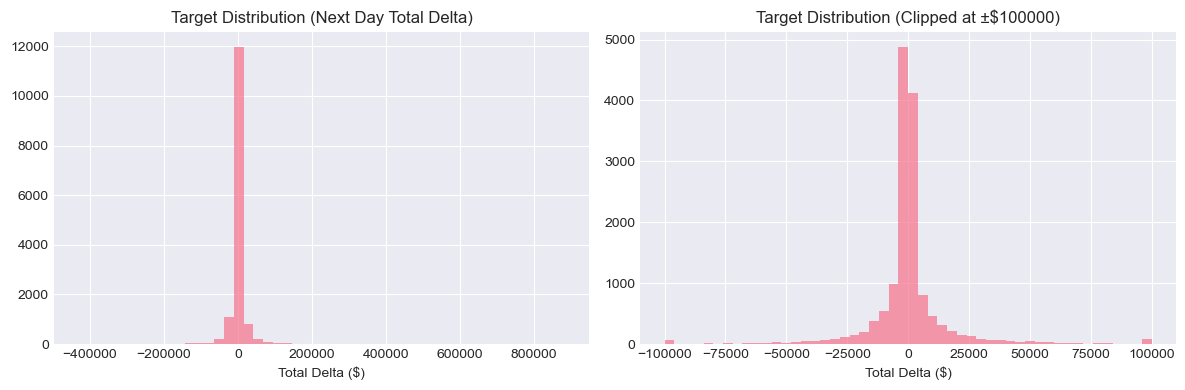

In [2]:
# %% [markdown]
# ## 2. Feature Engineering

# %% Engineer features
print("Engineering features...")
feature_engineer = FeatureEngineer(data_loader.config)

# Engineer features
features_df = feature_engineer.engineer_features(master_totals, master_fills)


# Get feature columns
feature_cols = feature_engineer.get_feature_columns(features_df)
print(f"Created {len(feature_cols)} features")
features_df.to_csv("data/processed/features_df.csv", index=False)

# Show target distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(features_df["target"], bins=50, alpha=0.7)
plt.title("Target Distribution (Next Day Total Delta)")
plt.xlabel("Total Delta ($)")

plt.subplot(1, 2, 2)
plt.hist(features_df["target"].clip(-100000, 100000), bins=50, alpha=0.7)
plt.title("Target Distribution (Clipped at ±$100000)")
plt.xlabel("Total Delta ($)")
plt.tight_layout()
plt.show()

In [3]:
display(features_df.head())
feature_cols

,symbol,orders_count,fills_count,qty,gross_pnl,net_pnl,unrealized_delta,total_delta,unrealized_pnl,date,...,qty_mean_20d,orders_mean_20d,win_rate_20d,sharpe_10d,sharpe_20d,recent_performance,is_loss,consecutive_losses,trading_days,historical_avg_total_delta
0,BURU,9,28,3400,-385.17,-407.206758,0.0,-407.206758,0.0,2023-04-05,...,3400.000000,9.000000,0.00,-0.039629,-0.033337,-407.206758,1,1,1,-407.206758
1,CMA,6,16,3200,-442.00,-459.839400,0.0,-459.839400,0.0,2023-04-05,...,3300.000000,7.500000,0.00,-11.648555,-11.648555,-867.046158,1,2,2,-433.523079
2,CR,2,6,1000,130.00,124.307000,0.0,124.307000,0.0,2023-04-05,...,2533.333333,5.666667,0.05,-0.766176,-0.766176,-742.739158,0,0,3,-247.579719
3,WAL,6,25,4000,129.85,111.429700,0.0,111.429700,0.0,2023-04-05,...,2900.000000,5.750000,0.10,-0.494580,-0.494580,-224.102700,0,0,4,-157.827364
4,PXD,41,91,9200,2197.09,2142.498868,0.0,2142.498868,0.0,2023-04-10,...,4160.000000,12.800000,0.15,0.283735,0.283735,2378.235568,0,0,5,302.237882


['orders_count',
 'fills_count',
 'gross_pnl',
 'net_pnl',
 'unrealized_pnl',
 'total_fees',
 'order_id_nunique',
 'symbol_nunique',
 'qty_sum',
 'qty_mean',
 'qty_std',
 'qty_max',
 'qty_count',
 'price_mean',
 'price_std',
 'price_min',
 'price_max',
 'total_fees_sum',
 'total_fees_mean',
 'target_negative',
 'is_monday',
 'is_friday',
 'net_rolling_5d',
 'net_mean_5d',
 'net_std_5d',
 'qty_mean_5d',
 'orders_mean_5d',
 'win_rate_5d',
 'net_rolling_10d',
 'net_mean_10d',
 'net_std_10d',
 'qty_mean_10d',
 'orders_mean_10d',
 'win_rate_10d',
 'net_rolling_20d',
 'net_mean_20d',
 'net_std_20d',
 'qty_mean_20d',
 'orders_mean_20d',
 'win_rate_20d',
 'sharpe_10d',
 'sharpe_20d',
 'recent_performance',
 'is_loss',
 'consecutive_losses',
 'trading_days',
 'historical_avg_total_delta']

In [4]:
# %% [markdown]
# ## 3. Train Models

# %% Split data
print("Creating train/val/test splits...")
model_trainer = ModelTrainer()
train_df, val_df, test_df = model_trainer.create_time_splits(features_df)

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} samples ({len(train_df['date'].unique())} days)")
print(f"Val: {len(val_df)} samples ({len(val_df['date'].unique())} days)")
print(f"Test: {len(test_df)} samples ({len(test_df['date'].unique())} days)")

# %% Train ARIMA baseline
print("\nTraining ARIMA baseline models...")
arima_models = model_trainer.train_arima_baseline(train_df, val_df)
print(f"Trained {len(arima_models)} ARIMA models")

# %% Train LightGBM models
print("\nTraining LightGBM models...")

# Train global model
global_model = model_trainer.train_global_model(train_df, val_df, feature_cols)

# Train personal models
personal_models = model_trainer.train_personal_models(train_df, val_df, feature_cols)

# %% [markdown]

2025-05-26 11:14:08,069 - INFO - Train: 9976 samples, Val: 2195 samples, Test: 2466 samples
2025-05-26 11:14:08,071 - INFO - Training ARIMA baseline models...
2025-05-26 11:14:08,072 - ERROR - Error training ARIMA for 3951: cannot reindex on an axis with duplicate labels
2025-05-26 11:14:08,074 - ERROR - Error training ARIMA for 3950: cannot reindex on an axis with duplicate labels
2025-05-26 11:14:08,075 - ERROR - Error training ARIMA for 3957: cannot reindex on an axis with duplicate labels
2025-05-26 11:14:08,082 - ERROR - Error training ARIMA for 3946: cannot reindex on an axis with duplicate labels
2025-05-26 11:14:08,098 - ERROR - Error training ARIMA for 4004: cannot reindex on an axis with duplicate labels
2025-05-26 11:14:08,101 - INFO - Training global regression model...


Creating train/val/test splits...

Split sizes:
Train: 9976 samples (496 days)
Val: 2195 samples (106 days)
Test: 2466 samples (105 days)

Training ARIMA baseline models...
Trained 0 ARIMA models

Training LightGBM models...
Training until validation scores don't improve for 50 rounds


2025-05-26 11:14:08,765 - INFO - Global model - RMSE: 31851.9040, MAE: 11260.6431, R2: 0.1764
2025-05-26 11:14:08,852 - INFO - Trained personal model for 3951


Early stopping, best iteration is:
[59]	valid_0's rmse: 31851.9
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 3607.47
Training until validation scores don't improve for 20 rounds


2025-05-26 11:14:09,021 - INFO - Trained personal model for 3950
2025-05-26 11:14:09,148 - INFO - Trained personal model for 3957


Early stopping, best iteration is:
[41]	valid_0's rmse: 8685.35
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 47117.4
Training until validation scores don't improve for 20 rounds


2025-05-26 11:14:09,269 - INFO - Trained personal model for 3946
2025-05-26 11:14:09,390 - INFO - Trained personal model for 4004
2025-05-26 11:14:09,391 - INFO - Trained 5 personal models


Early stopping, best iteration is:
[23]	valid_0's rmse: 971.303
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 11038.7


In [5]:
# ## 4. Evaluate Models

# %% Evaluate on test set
print("\nEvaluating models on test set...")
results = model_trainer.evaluate_models(
    test_df, global_model, personal_models, arima_models, feature_cols
)

# Save metadata
model_trainer.save_model_metadata(feature_cols, results)

# %% Display results
print("\n" + "=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)

for model_type, metrics in results.items():
    print(f"\n{model_type.upper()} MODEL:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# %% [markdown]

2025-05-26 11:14:09,408 - INFO - Global Model - RMSE: 24069.6540, MAE: 10145.4356, R2: 0.2751
2025-05-26 11:14:09,408 - INFO - Personal Models - RMSE: 11473.6077, MAE: 6303.0933, R2: 0.3112
2025-05-26 11:14:09,409 - INFO - ARIMA Baseline - RMSE: 0.0000, MAE: 0.0000, R2: 0.0000



Evaluating models on test set...

MODEL EVALUATION RESULTS

GLOBAL MODEL:
  rmse: 24069.6540
  mae: 10145.4356
  r2: 0.2751

PERSONAL MODEL:
  rmse_mean: 11473.6077
  mae_mean: 6303.0933
  r2_mean: 0.3112

ARIMA MODEL:
  rmse_mean: 0.0000
  mae_mean: 0.0000
  r2_mean: 0.0000


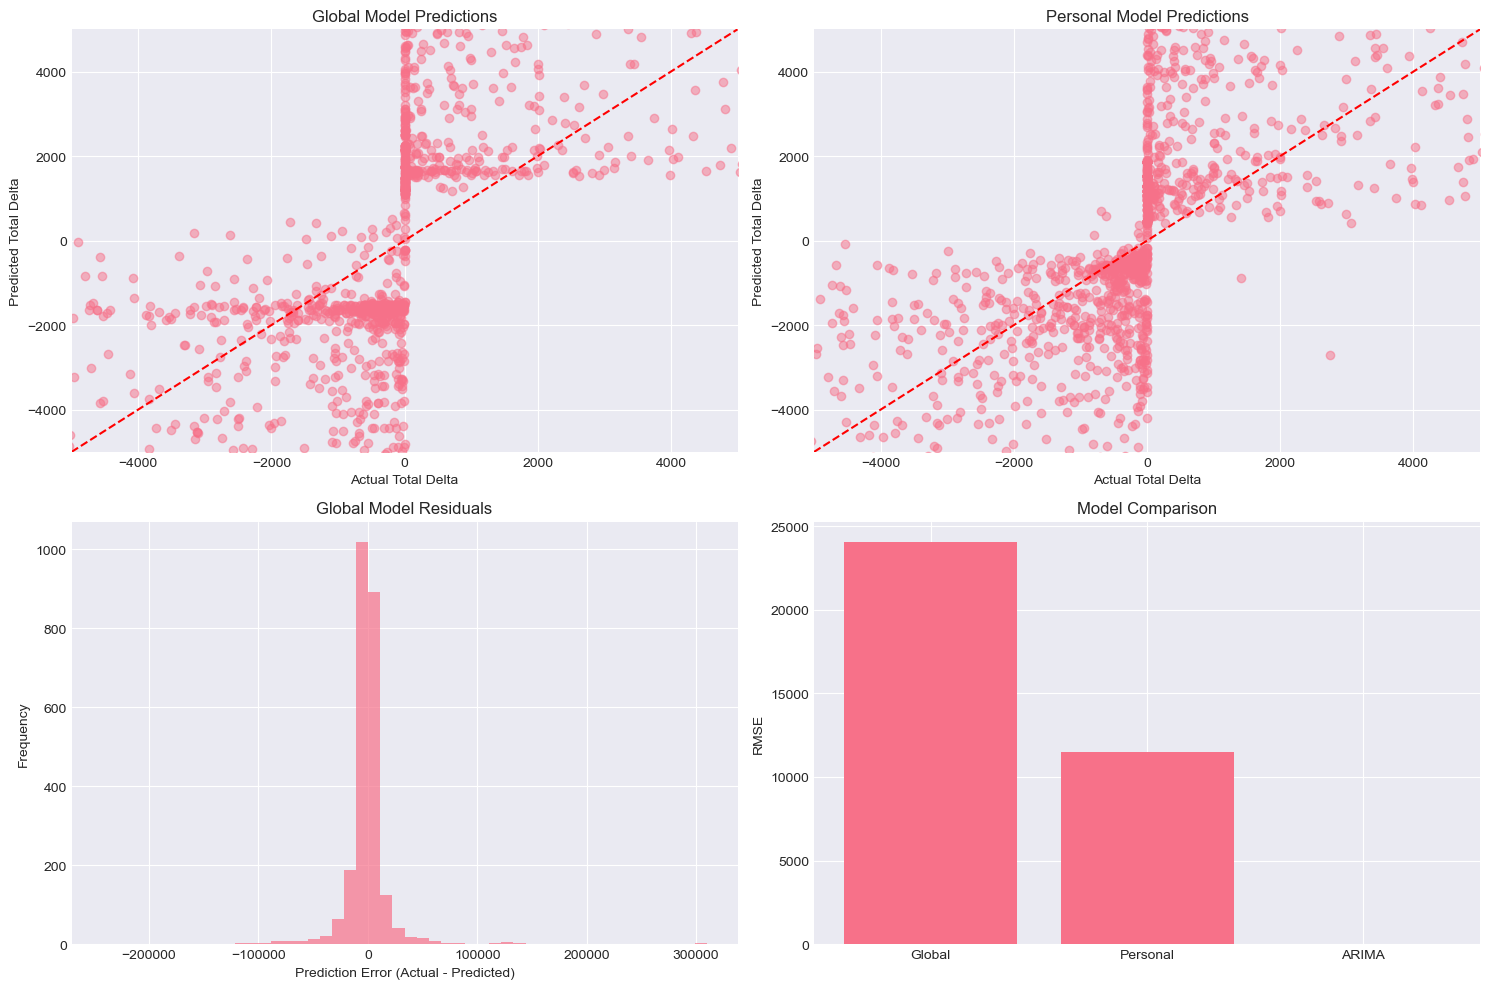

In [6]:
# ## 5. Detailed Analysis

# %% Compare predictions
# Get predictions for test set
test_predictions = pd.DataFrame()

# Global predictions
X_test = test_df[feature_cols]
test_predictions["actual"] = test_df["target"].values
test_predictions["global_pred"] = global_model.predict(X_test)
test_predictions["account_id"] = test_df["account_id"].values
test_predictions["date"] = test_df["date"].values

# Personal predictions
personal_preds = []
for idx, row in test_df.iterrows():
    account_id = row["account_id"]
    if account_id in personal_models:
        pred = personal_models[account_id].predict(
            row[feature_cols].values.reshape(1, -1)
        )[0]
    else:
        pred = np.nan
    personal_preds.append(pred)

test_predictions["personal_pred"] = personal_preds

# ARIMA predictions (simplified - just use last known value as forecast)
arima_preds = []
for idx, row in test_df.iterrows():
    account_id = row["account_id"]
    if account_id in arima_models:
        # For simplicity, use naive forecast
        pred = 0  # ARIMA models need proper forecasting setup
    else:
        pred = np.nan
    arima_preds.append(pred)

test_predictions["arima_pred"] = arima_preds

# %% Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Global model
axes[0, 0].scatter(
    test_predictions["actual"], test_predictions["global_pred"], alpha=0.5
)
axes[0, 0].plot([-5000, 5000], [-5000, 5000], "r--")
axes[0, 0].set_xlabel("Actual Total Delta")
axes[0, 0].set_ylabel("Predicted Total Delta")
axes[0, 0].set_title("Global Model Predictions")
axes[0, 0].set_xlim(-5000, 5000)
axes[0, 0].set_ylim(-5000, 5000)

# Personal models
valid_personal = test_predictions.dropna(subset=["personal_pred"])
if len(valid_personal) > 0:
    axes[0, 1].scatter(
        valid_personal["actual"], valid_personal["personal_pred"], alpha=0.5
    )
    axes[0, 1].plot([-5000, 5000], [-5000, 5000], "r--")
    axes[0, 1].set_xlabel("Actual Total Delta")
    axes[0, 1].set_ylabel("Predicted Total Delta")
    axes[0, 1].set_title("Personal Model Predictions")
    axes[0, 1].set_xlim(-5000, 5000)
    axes[0, 1].set_ylim(-5000, 5000)

# Residuals
axes[1, 0].hist(
    test_predictions["actual"] - test_predictions["global_pred"], bins=50, alpha=0.7
)
axes[1, 0].set_xlabel("Prediction Error (Actual - Predicted)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Global Model Residuals")

# Model comparison
model_rmse = pd.DataFrame(
    {
        "Model": ["Global", "Personal", "ARIMA"],
        "RMSE": [
            results["global"]["rmse"],
            results["personal"]["rmse_mean"],
            results["arima"]["rmse_mean"],
        ],
    }
)
axes[1, 1].bar(model_rmse["Model"], model_rmse["RMSE"])
axes[1, 1].set_ylabel("RMSE")
axes[1, 1].set_title("Model Comparison")

plt.tight_layout()
plt.show()

# %% [markdown]

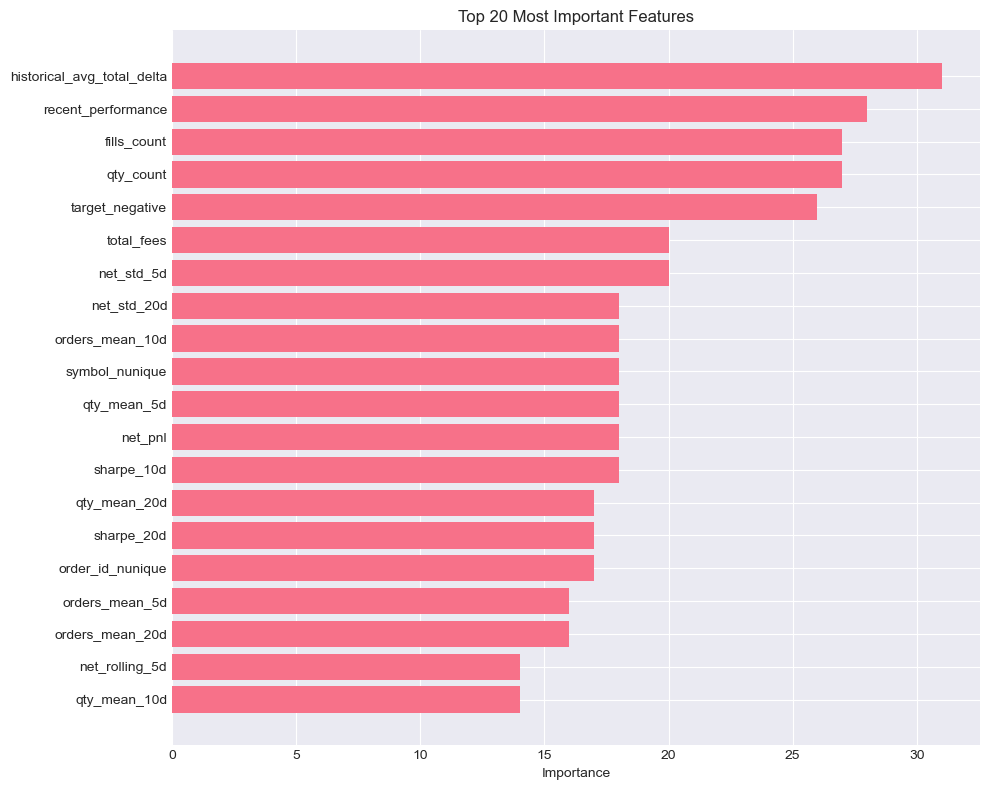

In [11]:
# ## 6. Feature Importance

# %% Feature importance
# Get global model feature importance
importance_df = (
    pd.DataFrame(
        {
            "feature": feature_cols,
            "importance": personal_models[3957].feature_importances_,
        }
    )
    .sort_values("importance", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Importance")
plt.title("Top 20 Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %% [markdown]

In [8]:
# ## 7. Risk Predictions for Tomorrow

# %% Generate predictions for tomorrow
print("\nGenerating risk predictions for tomorrow...")

# Prepare data for prediction
predictor_data = {}
for account_id, data in all_data.items():
    # Get the engineered features for this trader
    trader_features = features_df[features_df["account_id"] == account_id]
    if len(trader_features) > 0:
        predictor_data[account_id] = {"features": trader_features, "name": data["name"]}

# Initialize predictor and generate predictions
predictor = RiskPredictor()
predictions = predictor.predict_all_traders(predictor_data)

# Display high-risk traders
high_risk = [p for p in predictions if p["predicted_pnl"] < -500]
print(f"\nHigh Risk Traders (predicted loss > $500): {len(high_risk)}")
for trader in high_risk[:10]:  # Show top 10
    print(
        f"  {trader['trader_name']}: ${trader['predicted_pnl']:.2f} (confidence: {trader['confidence']})"
    )

# %% Save predictions
# Create predictions DataFrame
predictions_df = pd.DataFrame(predictions)
predictions_df["prediction_date"] = pd.Timestamp.now()
predictions_df.to_csv("data/predictions/latest_predictions.csv", index=False)

print("\nPredictions saved to data/predictions/latest_predictions.csv")

# %% [markdown]

2025-05-26 11:14:10,703 - INFO - Loaded global model, 9 personal models, and 0 ARIMA models
2025-05-26 11:14:10,722 - INFO - Generated predictions for 5 traders



Generating risk predictions for tomorrow...

High Risk Traders (predicted loss > $500): 2
  NEO006_OLD: $-9997.42 (confidence: Medium)
  NET010_OLD: $-1487.27 (confidence: Medium)

Predictions saved to data/predictions/latest_predictions.csv


In [9]:
# ## 8. Summary Report

# %% Generate summary
print("\n" + "=" * 60)
print("TRADING RISK MODEL - SUMMARY REPORT")
print("=" * 60)
print(f"\nData Period: {master_totals['date'].min()} to {master_totals['date'].max()}")
print(f"Number of Traders: {len(all_data)}")
print(f"Total Trading Days: {len(master_totals['date'].unique())}")
print(f"\nTest Period: Last {len(test_df['date'].unique())} days")
print(f"\nModel Performance (RMSE):")
print(f"  - Global LightGBM: ${results['global']['rmse']:.2f}")
print(f"  - Personal LightGBM (avg): ${results['personal']['rmse_mean']:.2f}")
print(f"  - ARIMA Baseline (avg): ${results['arima']['rmse_mean']:.2f}")
print(f"\nModel Performance (R²):")
print(f"  - Global LightGBM: {results['global']['r2']:.4f}")
print(f"  - Personal LightGBM (avg): {results['personal']['r2_mean']:.4f}")
print(f"  - ARIMA Baseline (avg): {results['arima']['r2_mean']:.4f}")
print(f"\nTop Risk Factors:")
for i, row in importance_df.head(5).iterrows():
    print(f"  - {row['feature']}: {row['importance']:.1f}")

print("\n" + "=" * 60)


TRADING RISK MODEL - SUMMARY REPORT

Data Period: 2023-04-03 00:00:00 to 2025-04-30 00:00:00
Number of Traders: 5
Total Trading Days: 707

Test Period: Last 105 days

Model Performance (RMSE):
  - Global LightGBM: $24069.65
  - Personal LightGBM (avg): $11473.61
  - ARIMA Baseline (avg): $0.00

Model Performance (R²):
  - Global LightGBM: 0.2751
  - Personal LightGBM (avg): 0.3112
  - ARIMA Baseline (avg): 0.0000

Top Risk Factors:
  - recent_performance: 111.0
  - qty_count: 102.0
  - historical_avg_total_delta: 84.0
  - net_std_20d: 83.0
  - fills_count: 63.0

